# Convolutional VAE

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torchvision.utils import save_image
from torchvision.utils import make_grid

import os
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Load Dataset

In [2]:
model_dir = './save_models/FMNIST/Conv_VAE'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

fmnist_train = dset.FashionMNIST('./data/FMNIST', train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = dset.FashionMNIST('./data/FMNIST', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

batch_size = 128

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 3. Build Model
### 3.1 Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, hidden_size):
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), # batch_size x 8 x 28 x 28
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, 3, padding=1), # batch_size x 16 x 14 x 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), # batch_size x 32 x 7 x 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.fc1_mu = nn.Sequential(
            nn.Linear(32*7*7, 800),
            nn.Linear(800, self.hidden_size)
        )
        
        self.fc1_sigma = nn.Sequential(
            nn.Linear(32*7*7, 800),
            nn.Linear(800, self.hidden_size)
        )
        
        self.relu = nn.ReLU()
        
    def encode(self, inputs):
        batch_size = inputs.size(0)
        
        out = self.layer1(inputs)
        out = out.view(batch_size, -1)
        out = self.relu(out)
        
        mu = self.fc1_mu(out)
        log_var = self.fc1_sigma(out)
        
        return mu, log_var
    
    def forward(self, inputs):
        mu, log_var = self.encode(inputs)
        noise = torch.randn(mu.size())
        
        if USE_CUDA:
            noise = noise.cuda()
            
        z = mu + log_var.exp() * noise
        
        return z, mu, log_var

### 3.2 Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.layer1 = nn.Sequential(
            nn.Linear(self.hidden_size, 800),
            nn.BatchNorm1d(800),
            nn.ReLU(),
            nn.Linear(800, 1568),
            nn.ReLU()
        )
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 1, 3, 1, 1),
            nn.BatchNorm2d(1)
        )
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        
        out = self.layer1(inputs)
        out = self.relu(out)
        out = out.view(batch_size, 32, 7, 7)
        out = self.deconv1(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, 1, 28, 28)
        
        return out

In [5]:
hidden_size = 100

encoder = Encoder(hidden_size)
decoder = Decoder(hidden_size)

if USE_CUDA:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

## 4. Loss func & Optims

In [6]:
reconstruction_function = nn.BCELoss(size_average=False)

def loss_function(recon_x, x, mu, log_var):
    BCE = reconstruction_function(recon_x, x)
    
    KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
    KLD = torch.sum(KLD_element).mul_(-.5)
    
    return BCE + KLD # compute loss

parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=0.0005)

In [7]:
try:
    encoder, decoder = torch.load(model_dir + '/conv_variational_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 5. Train

In [8]:
num_epoch = 20

for i in range(num_epoch):
    for j, (image, labels) in enumerate(train_loader):
        optimizer.zero_grad() # Zero Gradient Container
        
        if USE_CUDA:
            image = image.cuda()
            
        z, mu, log_var = encoder(image) # Forward Propagation
        output = decoder(z) 
        
        loss = loss_function(output, image, mu, log_var) # Compute cost
        
        loss.backward() # compute gradient
        optimizer.step() # gradient update
        
        if j % 10 == 0:
            torch.save([encoder,decoder],model_dir + '/conv_variational_autoencoder.pkl')
            
    print("[%d/%d] loss : %0.5f"%(i+1, num_epoch, loss.item()))

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[1/20] loss : 44442.68750
[2/20] loss : 41727.72656
[3/20] loss : 36760.36719
[4/20] loss : 35606.42969
[5/20] loss : 33393.72266
[6/20] loss : 33062.13672
[7/20] loss : 32991.14453
[8/20] loss : 31831.14648
[9/20] loss : 31606.36133
[10/20] loss : 30558.73242
[11/20] loss : 31201.64648
[12/20] loss : 29013.51367
[13/20] loss : 30401.76953
[14/20] loss : 29753.31641
[15/20] loss : 30694.66016
[16/20] loss : 27933.04492
[17/20] loss : 29682.86719
[18/20] loss : 30021.18359
[19/20] loss : 30751.51758
[20/20] loss : 30959.78906


## 6. Check Train Image

torch.Size([128, 28, 28])

 from train data image



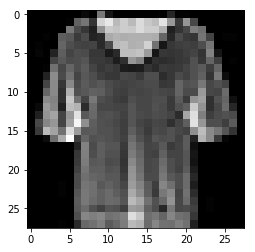


 from generated model's image



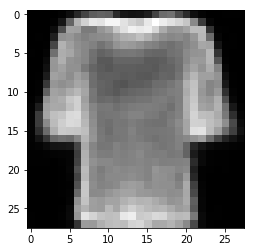


 from train data image



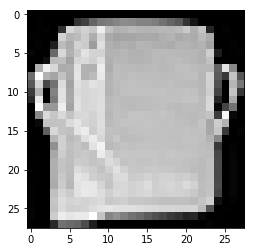


 from generated model's image



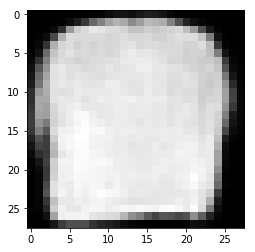


 from train data image



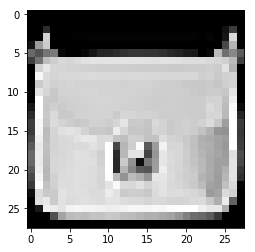


 from generated model's image



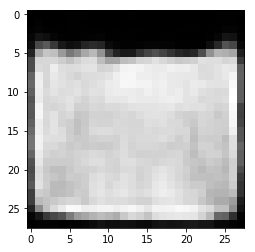


 from train data image



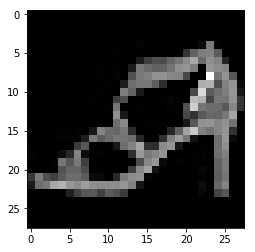


 from generated model's image



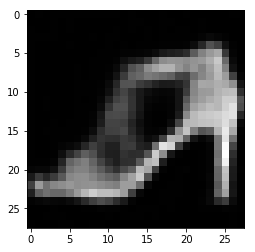


 from train data image



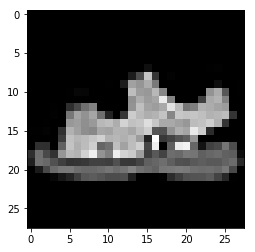


 from generated model's image



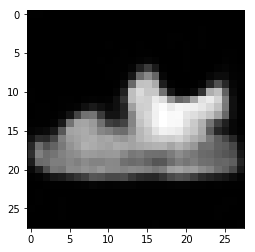

In [9]:
out_image = torch.squeeze(output.cpu().data)
print(out_image.size())

for i in range(5):
    print("\n from train data image\n")
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')
    plt.show()
    print("\n from generated model's image\n")
    plt.imshow(out_image[i].numpy(), cmap='gray')
    plt.show()

## 7. Check Test Image

In [10]:
for i in range(1):
    for j, (image, label) in enumerate(test_loader):
        if USE_CUDA:
            image = image.cuda()
            
        output, mean, var = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print("[%d/%d] loss : %0.5f"%(i+1, num_epoch, loss.item()))

torch.Size([128, 28, 28])

 from test data image



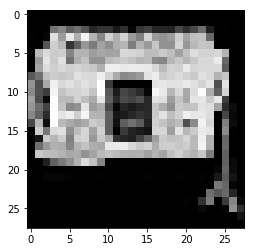


 from generated model's image



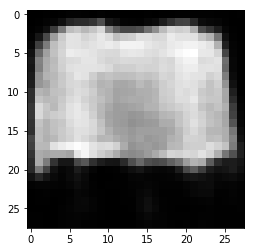


 from test data image



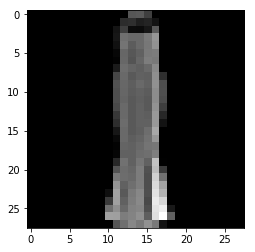


 from generated model's image



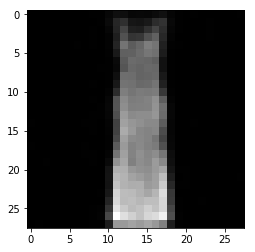


 from test data image



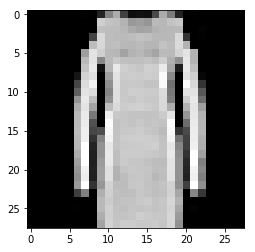


 from generated model's image



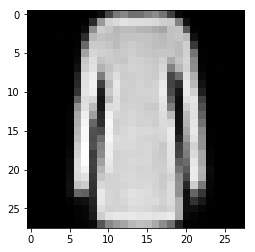


 from test data image



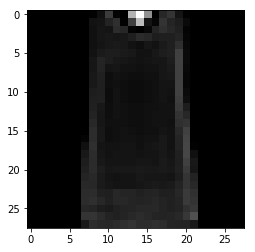


 from generated model's image



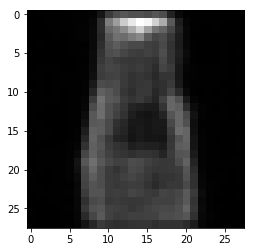


 from test data image



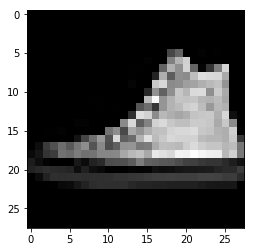


 from generated model's image



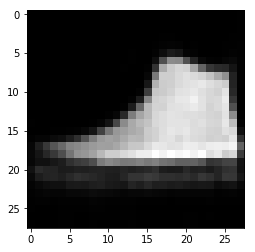

In [11]:
out_image = torch.squeeze(output.cpu().data)
print(out_image.size())

for i in range(5):
    print("\n from test data image\n")
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')
    plt.show()
    print("\n from generated model's image\n")
    plt.imshow(out_image[i].numpy(), cmap='gray')
    plt.show()